In [4]:
# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
import abcTau 

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from neurodsp.spectral import compute_spectrum
from timescales.fit import fit_acf, fit_psd, compute_acf, convert_knee_val
from timescales.sim import sim_spikes_synaptic

# abcTau vs ACF fitting vs SpecParam

Here, 500 1s trials are simulated with a tau corresponding to 10hz (with no oscillations). abcTau produces more accurate results than either fitting the ACF with an exponential or using SpecParam. However this is also at the expense of an exponentially longer compute time.

SpecParam could also be replace the generative model to be used with abcTau.

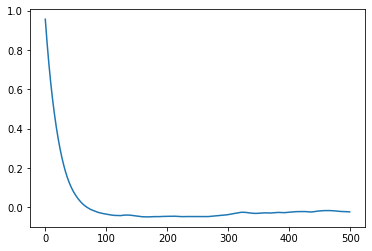

In [7]:
# Simulate
n_seconds = 1
fs = 1000
tau = 0.025 # corresonds to ~10hz

n_iters = 500
probs = np.zeros((n_iters, 1000))
for i in range(n_iters):
    _probs, _ = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1)
    probs[i] = _probs
    
corrs = compute_acf(probs, len(probs))
plt.plot(corrs.mean(axis=0))

### 1. Fit with basic exponential decay, taking the mean ACF across trials (or neurons) and fitting.

In [11]:
params = fit_acf(corrs.mean(axis=0), 1000)

freqs, powers = compute_spectrum(probs, fs)
_, _, knee_tau = fit_psd(freqs, powers.mean(axis=0), (0, 100))

print('Ground Truth: ', tau)
print('ACF         : ', params[0])
print('Spec        : ', knee_tau)

Ground Truth:  0.025
ACF         :  0.02148299769926104
Spec        :  0.022575723135084318


### 2. Use abctau to fit using PSD model

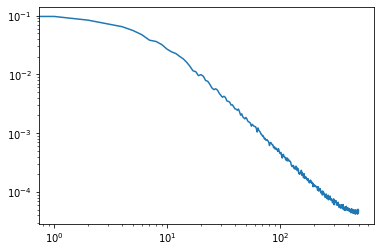

In [12]:
# path for loading and saving data
datasave_path = 'example_abc_results_/'
dataload_path = 'example_data_/'

# path and filename to save the intermediate results after running each step
inter_save_direc = 'example_abc_results/_'
inter_filename = 'abc_intermediate_results_psd_'

# define filename for loading and saving the results
filename = 'OU_tau20_mean0_var1_rawData_'
filenameSave = filename

# select summary statistics metric
summStat_metric = 'comp_psd'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = None # only used when suing autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials = \
    abcTau.preprocessing.extract_stats(probs, deltaT, binSize, summStat_metric, ifNorm, maxTimeLag)

plt.loglog(data_sumStat)

# Define the prior distribution
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t_min = 0.0 # first timescale
t_max = 100.0
priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]

# select generative model and distance function
generativeModel = 'oneTauOU'
distFunc = 'logarithmic_distance'

# set fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.05 # minimum acceptance rate to stop the iterations
parallel = True # if parallel processing
n_procs = -1 # number of processor for parallel processing (set to 1 if there is no parallel processing)


class MyModel(abcTau.Model):

    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d

In [14]:
# fit with aABC algorithm for any generative model
abc_results, final_step = abcTau.fit.fit_withABC(MyModel, data_sumStat, priorDist, inter_save_direc, inter_filename,\
                                                 datasave_path, filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, True, 12, disp)

Starting step 0
epsilon = 1
Running 9.0 particles on 12 processors
acceptence Rate = 0.6242774566473989
--------------------
Starting step 1
epsilon = 0.7262419873514225
Running 9.0 particles on 12 processors
acceptence Rate = 0.6136363636363636
--------------------
Starting step 2
epsilon = 0.46109246330519355
Running 9.0 particles on 12 processors
acceptence Rate = 0.5346534653465347
--------------------
Starting step 3
epsilon = 0.22656341642840894
Running 9.0 particles on 12 processors
acceptence Rate = 0.48868778280542985
--------------------
Starting step 4
epsilon = 0.12157464477117248
Running 9.0 particles on 12 processors
acceptence Rate = 0.5538461538461539
--------------------
Starting step 5
epsilon = 0.06954275444802921
Running 9.0 particles on 12 processors
acceptence Rate = 0.5294117647058824
--------------------
Starting step 6
epsilon = 0.047777765630556246
Running 9.0 particles on 12 processors
acceptence Rate = 0.5167464114832536
--------------------
Starting step 7


In [15]:
posterior, _, _, _, _, _, _, _ = abc_results[final_step-1]

### Results

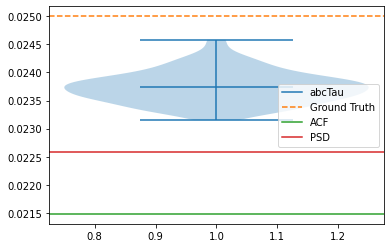

In [19]:
plt.violinplot(posterior[0] / fs, showmeans=True)
plt.plot([], label='abcTau', color='C0')
plt.axhline(tau, color='C1', ls='--', label='Ground Truth')
plt.axhline(params[0], color='C2', label='ACF')
plt.axhline(knee_tau, color='C3', label='PSD')
plt.legend()